In [53]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack as fft
from astropy.io import fits
from scipy import optimize
from poppy import zernike

%matplotlib notebook

Variables

In [54]:
outD = 7.77010  # primary diameter (m)
inD = 1.024  # inner M2 diameter (m)
m  = 8 

## GPI DM parameters
n = 48          # number sample points across the screen 
                # (Not the number of subapertures across the aperture which is less)
nacross = 43.2    # number of subapertures across the aperture
    
## phase sample parameters
pscale = outD/(nacross)   #  pixel size (m) of samples in pupil plane

aperture

In [55]:
x = np.linspace(-(n)/2,(n)/2,n)*pscale 
y = np.linspace(-(n)/2,(n)/2,n)*pscale
mg = np.meshgrid(x,y)
ar = np.sqrt(np.sum((m**2 for m in mg)))
ap_outer = (ar <= outD/2)
ap_inner = (ar <= inD/2)   
aperture = (ap_outer ^ ap_inner).astype(int)

In [56]:
aperture_nan = np.copy(aperture.astype(np.float))
aperture_nan[np.where(aperture==0)] = np.nan

open the file

In [57]:
#filename = "/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/aored_When_2016.2.27_0.40.14_poldm_phase.fits"
#filename = "/Users/melisatallis/Documents/Research/GPIDomeSeeing/data/aotelem/aored_When_2016.2.29_22.29.18_poldm_phase.fits"
filename = "/Users/MelisaT/Documents/Research/GPIDomeSeeing/data/Reduced/20160227/aored_When_2016.2.27_0.24.32_poldm_phase.fits"


hdulist = fits.open(filename,memmap=True)
phase = hdulist[0].data.astype('float')

# Get the phase dimensions
phdim = phase.shape 
phx   = phdim[1]
phy   = phdim[2]
timesteps = phdim[0]

print(phdim)

(22102, 48, 48)


In [58]:
avg_phase = np.nanmean(phase*aperture_nan,axis=0)

/Users/MelisaT/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


remove zernikes

In [72]:
z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)
z_coeff = zernike.opd_expand_nonorthonormal(avg_phase, aperture=aperture, nterms=6)
thin_lens = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)

c_phase = (phase - thin_lens[None,:,:])*aperture_nan
c_phase[np.isnan(c_phase)]=0.
print('Done removing zernikes')

Done removing zernikes


In [31]:
## Remove zernikes
thin_lens = np.zeros((timesteps,phx,phy), dtype=float)
z_basis = zernike.zernike_basis_faster(nterms= 6, npix = 48)

for t in np.arange(timesteps):
    z_coeff = zernike.opd_expand_nonorthonormal(phase[t], aperture=aperture, nterms=6)
    thin_lens[t,:,:] = np.sum(z_coeff[:,None,None]*z_basis[:,:,:],axis=0)
print('Done calculating zernikes')

c_phase = (phase - thin_lens)*aperture_nan
c_phase[np.isnan(c_phase)]=0.

Done calculating zernikes


Compute 2d fourier transform

In [73]:
phFT = np.zeros((timesteps,phx,phy), dtype=complex)
for t in np.arange(timesteps):
    phFT[t,:,:] = fft.fftshift(fft.fft2(c_phase[t,:,:]))/aperture.sum()
print('Done with FT')

Done with FT


Make frequency grid

In [61]:
kx = fft.fftshift(fft.fftfreq(phx,pscale))
ky = fft.fftshift(fft.fftfreq(phy,pscale))
mg = np.meshgrid(kx,ky)
kr = np.sqrt(np.sum((m**2 for m in mg))) 

Make psd

In [74]:
psd2D = np.zeros((timesteps, phx, phy),dtype=float)
for k in np.arange(phx):
    for l in np.arange(phy):
        psd2D[:,k,l] = np.abs(phFT[:,k,l])**2
        
avg_psd2D = np.mean(psd2D, axis=0)

In [15]:
def radialProfile(image, center=None):
    """
    Calculate the avearge radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    ## Calculate the indices from the image
    y,x = np.indices((image.shape)) # first determine radii of all pixels
    
    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
     
    r = np.hypot(x - center[0], y - center[1]).astype(np.int) 
    
    n = np.bincount(r.ravel())
    sy = np.bincount(r.ravel(), image.ravel())
    sy2 = np.bincount(r.ravel(), image.ravel()*image.ravel())
    mean = sy/n
    std = np.sqrt(sy2/n - mean*mean)
    
    return mean



psd plot

In [16]:
def implot(image, display=True, **kwargs):
    """Plot an image with colorbar.
    
    image - The 2d image
    kwargs - settings for curstomizing plot"""

    ## Create matplotlib figure 
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    cax = ax.imshow(image, cmap = plt.cm.Greys, origin='lower', interpolation='none')
    cbar = fig.colorbar(cax, orientation='vertical')

    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=24)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=16)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=16)
    if 'cbar_label' in kwargs: cbar.set_label(kwargs['cbar_label'], 
                                              fontsize=18)
    if 'save_image' in kwargs: plt.savefig(kwargs['save_image'])

    if display: plt.show()

In [65]:
def PSDplot(psd, freq, low_bound = 0., up_bound = 2.5, display=True, **kwargs):
    """Plot the 1D psd"""
    
    ##  create matplotlib figure
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    def func(x, a, b):
        return a+(b*x) 
    
    par,pcov = optimize.curve_fit(func,np.log10(freq[(freq > low_bound) & (freq < up_bound)]),
                                  np.log10(psd[(freq > low_bound) & (freq < up_bound)]), p0=(1, -3.5))
    slope = par[0]
    intercept = par[1]
    
    ## Plot original PSD and linear fit
    img = ax.loglog((freq[(freq > low_bound) & (freq < up_bound)]),(psd[(freq > low_bound) & (freq < up_bound)]),
                    'b.',(freq[(freq > low_bound) & (freq < up_bound)]),
                    10**(func(np.log10(freq[(freq > low_bound) & (freq < up_bound)]),*par)), 'r')

    ax.legend(['PSD', 'slope = {0:.2f}, intercept={1:.2f}'.format(slope, intercept)],loc=3, fontsize=10)
    ax.minorticks_on()
    ax.grid(b=True, which='major', color='grey', linestyle='-')
    ax.set_ylabel('Power Spectrum')
    ax.set_xlabel('Spatial Frequency')
    
    ## Modify plot based on keyword arguments
    if 'title' in kwargs: ax.set_title(kwargs['title'], fontsize=10)
    if 'xlabel' in kwargs: ax.set_xlabel(kwargs['xlabel'], fontsize=15)
    if 'ylabel' in kwargs: ax.set_ylabel(kwargs['ylabel'], fontsize=15)
    if display: plt.show()

1d psd

In [75]:
avg_psd1D =  radialProfile(avg_psd2D)


<IPython.core.display.Javascript object>


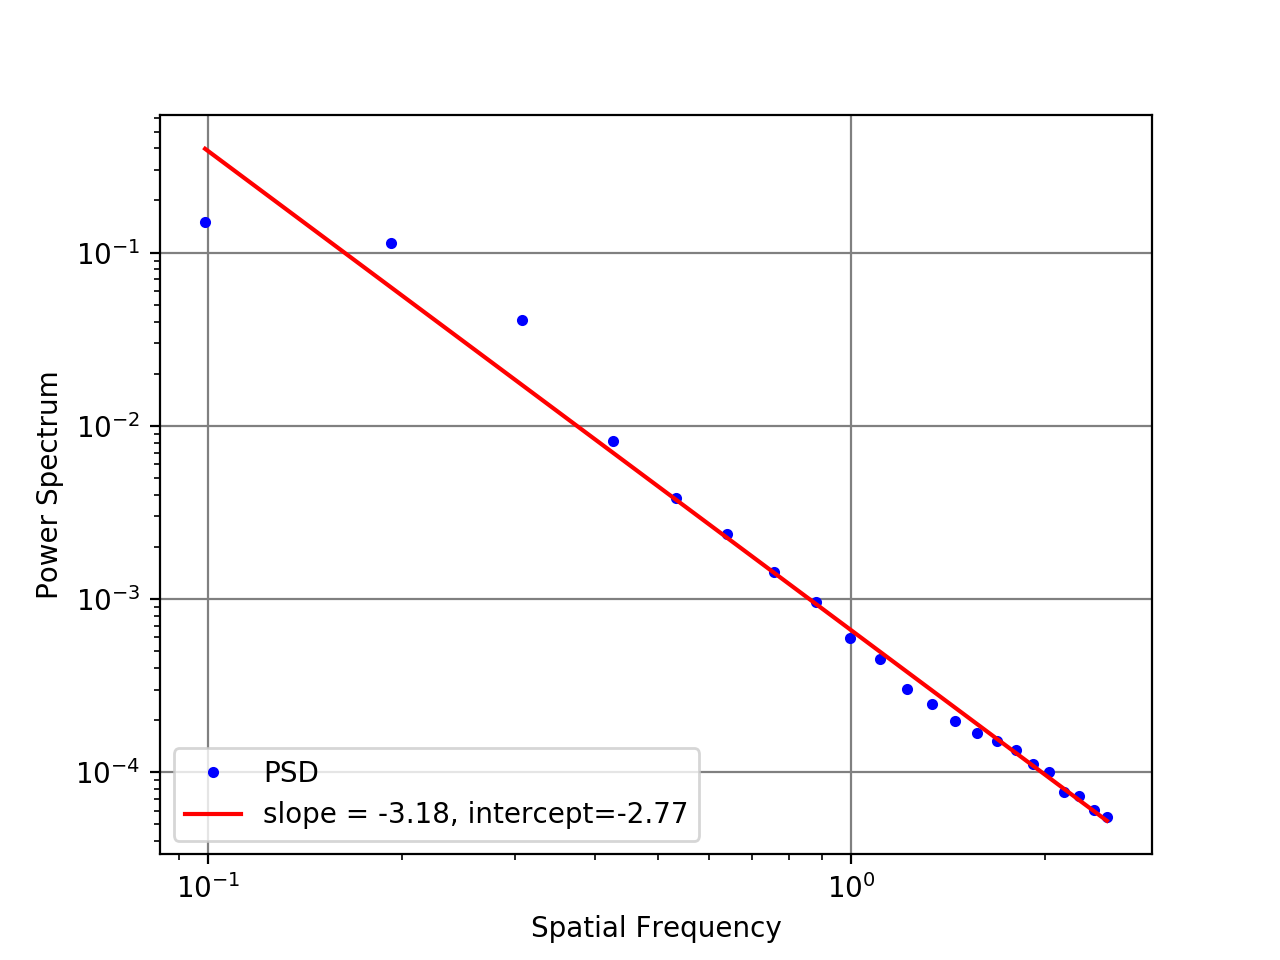

In [76]:
%matplotlib notebook

PSDplot(avg_psd1D,radialProfile(kr))
#PSDplot(avg_psd2D.ravel(),kr.ravel())
